In [1]:
import os
import torch
import torch_directml
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

root_dir = r'C:\Users\rauls\OneDrive\Documentos\2-Facul-Programming\CarClassifier'

In [2]:
# Define paths and parameters
train_cars_dataset_path = os.path.join(root_dir,'src/data/cars_train/train')
test_cars_dataset_path = os.path.join(root_dir,'src/data/cars_train/test')
mean = [0.4708, 0.4602, 0.4550]
std = [0.2593, 0.2584, 0.2634]

train_cars_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_cars_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

train_cars_dataset = ImageFolder(root=train_cars_dataset_path, transform=train_cars_transforms)
test_cars_dataset = ImageFolder(root=test_cars_dataset_path, transform=test_cars_transforms)

train_cars_loader = DataLoader(train_cars_dataset, batch_size=32, shuffle=True)
test_cars_loader = DataLoader(test_cars_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([ 80,  73, 111,  82, 153,  35])


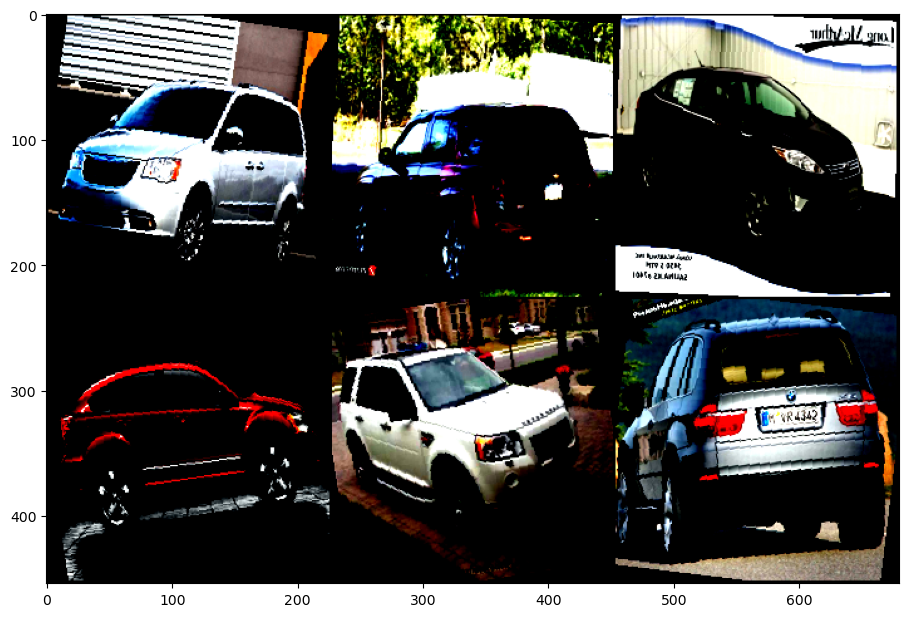

In [3]:
def show_transformed_images(dataset: ImageFolder, num_images: int = 6):
  loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch

  print(f"Labels: {labels}")
  grid = torchvision.utils.make_grid(images, nrow=3)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1, 2, 0)))
  plt.show()

show_transformed_images(train_cars_dataset)

In [4]:
def get_device():
  """
  Returns the device to use for computations.
  Prioritizes DirectML device if available, otherwise falls back to CPU.
  """
  device = torch_directml.device() if torch_directml.is_available() else torch.device("cpu")
  return device

def save_checkpoint(model: torch.nn.Module, epoch: int, optimizer: torch.optim.Optimizer, best_acc: float):
    state = {
        'model': model.state_dict(),
        'epoch': epoch,
        'optimizer': optimizer.state_dict(),
        'best_acc': best_acc
    }
    torch.save(state, 'best_cars_model_checkpoint.pth.tar')

def train_cars_nn(model: torch.nn.Module, train_loader: DataLoader, test_loader: DataLoader, criterion: torch.nn.CrossEntropyLoss, optimizer: torch.optim.Optimizer, n_epochs: int):
    device = get_device()
    best_acc = 0

    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for images, labels in tqdm(train_loader, desc='Training loop'):
            images, labels = images.to(device), labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * running_correct / total

        print(f"    Training: Predicted {running_correct} of {total} images correctly (Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.2f}%)")

        eval_acc = evaluate_model(model, test_loader)

        if eval_acc > best_acc:
            best_acc = eval_acc
            save_checkpoint(model, epoch + 1, optimizer, best_acc)

    return model

def evaluate_model(model: torch.nn.Module, test_loader: DataLoader):
    model.eval()
    device = get_device()
    predicted_correctly = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_correctly += (predicted == labels).sum().item()

    accuracy = 100 * predicted_correctly / total
    print(f"    Testing: Predicted {predicted_correctly} of {total} images correctly (Acc: {accuracy:.2f}%)")

    return accuracy

In [5]:
resnet18_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
n_features = resnet18_model.fc.in_features
n_classes = len(train_cars_dataset.classes)
resnet18_model.fc = torch.nn.Linear(n_features, n_classes)
device = get_device()
resnet18_model = resnet18_model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

train_cars_nn(resnet18_model, train_cars_loader, test_cars_loader, loss_fn, optimizer, n_epochs=20)

Epoch 1/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 731.0 of 6442 images correctly (Loss: 4.3557 - Acc: 11.35%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 378 of 1702 images correctly (Acc: 22.21%)
Epoch 2/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 2727.0 of 6442 images correctly (Loss: 2.3032 - Acc: 42.33%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 582 of 1702 images correctly (Acc: 34.20%)
Epoch 3/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 4081.0 of 6442 images correctly (Loss: 1.4457 - Acc: 63.35%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 878 of 1702 images correctly (Acc: 51.59%)
Epoch 4/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 4845.0 of 6442 images correctly (Loss: 1.0062 - Acc: 75.21%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 932 of 1702 images correctly (Acc: 54.76%)
Epoch 5/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5314.0 of 6442 images correctly (Loss: 0.7437 - Acc: 82.49%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1010 of 1702 images correctly (Acc: 59.34%)
Epoch 6/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5556.0 of 6442 images correctly (Loss: 0.6031 - Acc: 86.25%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1061 of 1702 images correctly (Acc: 62.34%)
Epoch 7/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5841.0 of 6442 images correctly (Loss: 0.4605 - Acc: 90.67%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1066 of 1702 images correctly (Acc: 62.63%)
Epoch 8/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6029.0 of 6442 images correctly (Loss: 0.3591 - Acc: 93.59%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1166 of 1702 images correctly (Acc: 68.51%)
Epoch 9/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6109.0 of 6442 images correctly (Loss: 0.3208 - Acc: 94.83%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1135 of 1702 images correctly (Acc: 66.69%)
Epoch 10/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6125.0 of 6442 images correctly (Loss: 0.3160 - Acc: 95.08%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1148 of 1702 images correctly (Acc: 67.45%)
Epoch 11/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6133.0 of 6442 images correctly (Loss: 0.3177 - Acc: 95.20%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1060 of 1702 images correctly (Acc: 62.28%)
Epoch 12/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6072.0 of 6442 images correctly (Loss: 0.3702 - Acc: 94.26%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 961 of 1702 images correctly (Acc: 56.46%)
Epoch 13/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6135.0 of 6442 images correctly (Loss: 0.3317 - Acc: 95.23%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1119 of 1702 images correctly (Acc: 65.75%)
Epoch 14/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6074.0 of 6442 images correctly (Loss: 0.3686 - Acc: 94.29%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1049 of 1702 images correctly (Acc: 61.63%)
Epoch 15/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6060.0 of 6442 images correctly (Loss: 0.3798 - Acc: 94.07%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1012 of 1702 images correctly (Acc: 59.46%)
Epoch 16/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6089.0 of 6442 images correctly (Loss: 0.3798 - Acc: 94.52%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1046 of 1702 images correctly (Acc: 61.46%)
Epoch 17/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6036.0 of 6442 images correctly (Loss: 0.4166 - Acc: 93.70%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 876 of 1702 images correctly (Acc: 51.47%)
Epoch 18/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5883.0 of 6442 images correctly (Loss: 0.5004 - Acc: 91.32%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 817 of 1702 images correctly (Acc: 48.00%)
Epoch 19/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5939.0 of 6442 images correctly (Loss: 0.4666 - Acc: 92.19%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 953 of 1702 images correctly (Acc: 55.99%)
Epoch 20/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6076.0 of 6442 images correctly (Loss: 0.3605 - Acc: 94.32%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1065 of 1702 images correctly (Acc: 62.57%)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
checkpoint = torch.load(os.path.join(root_dir, 'src/best_cars_model_checkpoint.pth.tar'))

resnet18_model = torchvision.models.resnet18()
n_features = resnet18_model.fc.in_features
n_classes = len(train_cars_dataset.classes)
resnet18_model.fc = torch.nn.Linear(n_features, n_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, os.path.join(root_dir, 'src/best_cars_model.pth'))